In [1]:
# 导入包
import pandas as pd
import numpy as np
## 标准化数值变量
from sklearn.preprocessing import StandardScaler
## 绘图
import matplotlib.pyplot as plt
import seaborn as sns
## 数据集分成训练集和测试集
from sklearn.model_selection import train_test_split
## 评价训练模型在测试集的得分
from sklearn.model_selection import cross_val_score
## 特征选择
from sklearn.feature_selection import SelectKBest
## 创建逻辑回归模型
from sklearn.linear_model import LogisticRegression

In [2]:
# 导入数据集
df = pd.read_csv('prosperLoanData.csv',parse_dates=['ListingCreationDate','DateCreditPulled','LoanOriginationDate'])

In [3]:
# 查看数据集
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null datetime64[ns]
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating 

In [4]:
df['LoanStatus'].unique()

array(['Completed', 'Current', 'Past Due (1-15 days)', 'Defaulted',
       'Chargedoff', 'Past Due (16-30 days)', 'Cancelled',
       'Past Due (61-90 days)', 'Past Due (31-60 days)',
       'Past Due (91-120 days)', 'FinalPaymentInProgress',
       'Past Due (>120 days)'], dtype=object)

In [5]:
# 数据评估

## 1.将数据集按照贷款生成日期(LoanOriginationDate)以2009年7月1日为节点分成两部分，因为在此日期前后采用的是不同的信用等级机制。我们研究2009.7.1以后。
## 2.将'LoanStatus'多个还款状态改成还款和违约（分别用1和0表示）；

In [6]:
# 数据清洗

## 获取2009.7.1以后数据集
df_clean = df[df['LoanOriginationDate']>='2009-07-01']
#df_clean.info()

In [7]:
## 测试
df_clean['LoanOriginationDate'].min()

Timestamp('2009-07-20 00:00:00')

In [8]:
## 将'LoanStatus'多个还款状态改成还款和违约（分别用1和0表示）

"""
因为数据集中各贷款状态（LoanStatus）的样本数量悬殊较大，同时参考Proper对各贷款状态的说明（Past Due四个月后才进入Chargedoff状态），
我将原先的12种状态划分为重点研究的是三种状态，即完成（包括Completed和FinalPaymentInProgress）、
未完成（包括Defaulted、Chargedoff和各种Past Due）和正在完成（Current）,分别标记为"Completed"，"Current"和"Defaulted"。
另外取消（Cancelled）状态只有5个样本，直接删除该等级。
"""

### 完成状态
df_clean['LoanStatus'].replace('FinalPaymentInProgress','Completed',inplace=True)

### 违约状态
defaults = ['Chargedoff','Past Due (1-15 days)','Past Due (16-30 days)',
           'Past Due (31-60 days)','Past Due (61-90 days)',
           'Past Due (91-120 days)','Past Due (>120 days)']

for default in defaults:
    df_clean['LoanStatus'].replace(default,'Defaulted',inplace=True)

### 删除‘Cancelled’和'Current'
df_clean = df_clean[~(df_clean['LoanStatus'].isin(['Cancelled','Current']))]

### 'Completed'替换为1，'Defaulted'替换为0
df_clean['LoanStatus'] = df_clean['LoanStatus']=='Completed'  

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [9]:
## 测试
df_clean['LoanStatus'].unique()

array([False,  True])

In [10]:
## 准备建模数据集——去除无关列
df_model = df_clean.drop(['ListingKey',
                          'ListingNumber',
                          'ListingCreationDate',
                          'CreditGrade',
                          'ClosedDate',
                          'ProsperRating (Alpha)',
                          'GroupKey',
                          'DateCreditPulled',
                          'LoanKey',
                          'LoanOriginationDate',
                          'LoanNumber',
                          'LoanOriginationDate',
                          'MemberKey'],
                           axis=1)

In [11]:
## 缺失值处理
### 缺失值较多——>1.下述列中的缺失值代表该客户之前没有Prosper贷款记录
missing_value_cols = {'TotalProsperLoans':0,'TotalProsperPaymentsBilled':0,
                      'OnTimeProsperPayments':0,'ProsperPaymentsLessThanOneMonthLate':0,
                      'ProsperPaymentsOneMonthPlusLate':0,'ProsperPrincipalBorrowed':0,
                      'ProsperPrincipalOutstanding':0,'ScorexChangeAtTimeOfListing':0}

### 检测上述特征值空值位置是否相同
df_model[df_model['TotalProsperLoans'].isnull()][list(missing_value_cols.keys())].sum()  #结果是0，表示空值位置相同

### 引入新的特征"之前是否办理过Prosper贷款"('PriorLoans')，是为1，否为0

df_model['PriorLoans'] = np.nan
df_model.loc[df_model['TotalProsperLoans'].isnull(),'PriorLoans'] = 0
df_model.loc[df_model['TotalProsperLoans'].notnull(),'PriorLoans'] = 1
df_model['PriorLoans'].unique()

array([0., 1.])

In [12]:
### 将missing_value_cols键所表示的列的缺失值填充为0
df_model.fillna(missing_value_cols,inplace=True)
df_model[list(missing_value_cols.keys())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28408 entries, 12 to 113935
Data columns (total 8 columns):
TotalProsperLoans                      28408 non-null float64
TotalProsperPaymentsBilled             28408 non-null float64
OnTimeProsperPayments                  28408 non-null float64
ProsperPaymentsLessThanOneMonthLate    28408 non-null float64
ProsperPaymentsOneMonthPlusLate        28408 non-null float64
ProsperPrincipalBorrowed               28408 non-null float64
ProsperPrincipalOutstanding            28408 non-null float64
ScorexChangeAtTimeOfListing            28408 non-null float64
dtypes: float64(8)
memory usage: 2.0 MB


In [13]:
### 缺失值较多——>2.‘LoanFirstDefaultedCycleNumber’缺失值表示贷款尚未拖欠，此处用0替换缺失值
df_model['LoanFirstDefaultedCycleNumber'].fillna(0,inplace=True)

In [14]:
### 缺失值较少的列，采取将缺失值直接删除

df_model.dropna(inplace=True)

In [15]:
## 'FirstRecordedCreditLine'表示第一次办理授信额度的日期，这里只提取年份。
df_model['FirstRecordedCreditLineYear'] = df_model['FirstRecordedCreditLine'].str[0:4]
df_model.drop('FirstRecordedCreditLine',axis=1,inplace=True)

In [16]:
## 查看处理后的数据集
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25046 entries, 12 to 113935
Data columns (total 70 columns):
Term                                   25046 non-null int64
LoanStatus                             25046 non-null bool
BorrowerAPR                            25046 non-null float64
BorrowerRate                           25046 non-null float64
LenderYield                            25046 non-null float64
EstimatedEffectiveYield                25046 non-null float64
EstimatedLoss                          25046 non-null float64
EstimatedReturn                        25046 non-null float64
ProsperRating (numeric)                25046 non-null float64
ProsperScore                           25046 non-null float64
ListingCategory (numeric)              25046 non-null int64
BorrowerState                          25046 non-null object
Occupation                             25046 non-null object
EmploymentStatus                       25046 non-null object
EmploymentStatusDuration       

In [17]:
# 特征工程

## 1.分类变量转换('BorrowerState','Occupation','EmploymentStatus','IncomeRange','LoanOriginationQuarter','FirstRecordedCreditLineYear')

categorical_vars = ['Term',
                    'BorrowerState',
                    'Occupation',
                    'EmploymentStatus',
                    'IncomeRange',
                    'LoanOriginationQuarter',
                    'FirstRecordedCreditLineYear']

for var in categorical_vars:
    df_model[var] = df_model[var].astype('category')

print(df_model['Term'].nunique())   
print(df_model['BorrowerState'].nunique())
print(df_model['Occupation'].nunique())
print(df_model['EmploymentStatus'].nunique())
print(df_model['IncomeRange'].nunique())
print(df_model['LoanOriginationQuarter'].nunique())
print(df_model['FirstRecordedCreditLineYear'].nunique())


### 为了后面的数据分析（特征相关性图的绘制），先创建数据集副本，将所有分类变量factorize
df_model_copy = df_model.copy()
for var_copy in categorical_vars:
    df_model_copy[var_copy] = pd.factorize(df_model_copy[var_copy])[0]
print(df_model_copy[categorical_vars].head())
      
      

### 对于分类变量'Term','EmploymentStatus'和‘IncomeRange’，采取虚拟变量的方法转换

df_model['Term'] = pd.get_dummies(df_model['Term'])
df_model['EmploymentStatus'] = pd.get_dummies(df_model['EmploymentStatus'])
df_model['IncomeRange'] = pd.get_dummies(df_model['IncomeRange'])

### 对于分类变量'BorrowerState','Occupation','LoanOriginationQuarter','FirstRecordedCreditLineYear',采取factorize

df_model['BorrowerState'] = pd.factorize(df_model['BorrowerState'])[0]
df_model['Occupation'] = pd.factorize(df_model['Occupation'])[0]
df_model['LoanOriginationQuarter'] = pd.factorize(df_model['LoanOriginationQuarter'],sort=True)[0]
df_model['FirstRecordedCreditLineYear'] = pd.factorize(df_model['FirstRecordedCreditLineYear'],sort=True)[0]

3
48
66
7
6
19
59
    Term  BorrowerState  Occupation  EmploymentStatus  IncomeRange  \
12     0              0           0                 0            0   
15     0              1           1                 1            1   
23     0              2           2                 0            0   
26     1              3           3                 0            0   
27     0              4           4                 2            2   

    LoanOriginationQuarter  FirstRecordedCreditLineYear  
12                       0                            0  
15                       1                            1  
23                       2                            2  
26                       3                            3  
27                       4                            4  


In [18]:
## 2.数值变量转换(量纲不一)

numeric_vars = ['BorrowerAPR',
                'BorrowerRate',
                'LenderYield',
                'EstimatedEffectiveYield',
                'EstimatedLoss',
                'EstimatedReturn',
                #'ProsperRating (numeric)',
                #'ProsperScore',
                #'ListingCategory (numeric)',
                'EmploymentStatusDuration',
                'CreditScoreRangeLower',
                'CreditScoreRangeUpper',
                'CurrentCreditLines',
                'OpenCreditLines',
                'TotalCreditLinespast7years',
                'OpenRevolvingAccounts',
                'OpenRevolvingMonthlyPayment',
                'InquiriesLast6Months',
                'TotalInquiries',
                'CurrentDelinquencies',
                'AmountDelinquent',
                'DelinquenciesLast7Years',
                'PublicRecordsLast10Years',
                'PublicRecordsLast12Months',
                'RevolvingCreditBalance',
                'BankcardUtilization',
                'AvailableBankcardCredit',
                'TotalTrades',
                'TradesNeverDelinquent (percentage)',  #已经是0-1之间的数值
                'TradesOpenedLast6Months',
                'DebtToIncomeRatio',
                'StatedMonthlyIncome',
                'TotalProsperLoans',
                'TotalProsperPaymentsBilled',
                'OnTimeProsperPayments',
                'ProsperPaymentsLessThanOneMonthLate',
                'ProsperPaymentsOneMonthPlusLate',
                'ProsperPrincipalBorrowed',
                'ProsperPrincipalOutstanding',
                'ScorexChangeAtTimeOfListing',
                'LoanCurrentDaysDelinquent',
                'LoanFirstDefaultedCycleNumber',
                'LoanMonthsSinceOrigination',
                'LoanOriginalAmount',
                'MonthlyLoanPayment',
                'LP_CustomerPayments',# 等于下面两个特征的和
                'LP_CustomerPrincipalPayments',
                'LP_InterestandFees',
                'LP_ServiceFees',
                'LP_CollectionFees',
                'LP_GrossPrincipalLoss',
                'LP_NetPrincipalLoss',
                'LP_NonPrincipalRecoverypayments',
                'PercentFunded',#已经是0-1之间的数值
                'Recommendations',
                'InvestmentFromFriendsCount',
                'InvestmentFromFriendsAmount',
                'Investors']

#for var in numeric_vars:
    #print(df_model[var].min(),df_model[var].max())
    
### 标准化上述数值变量
scaler = StandardScaler().fit(df_model[numeric_vars])
df_model[numeric_vars] = scaler.transform(df_model[numeric_vars])

In [19]:
## 测试
df_model[numeric_vars].head()

,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
12,-0.763923,-0.876909,-0.876688,-0.619621,-0.726826,-0.885772,-1.046803,-0.387415,-0.387415,-0.143865,...,0.939626,0.164712,-0.384084,-0.379617,-0.108914,0.113685,-0.123796,-0.108234,-0.055209,-0.920346
15,1.231181,1.215810,1.215917,1.433423,1.374459,0.480804,0.298345,-0.008754,-0.008754,0.044176,...,0.823677,0.164712,0.963381,0.982849,-0.108914,0.113685,-0.123796,-0.108234,-0.055209,-0.830727
23,0.362212,0.305201,0.305357,0.464769,0.301423,-0.045841,-1.024383,-0.387415,-0.387415,-0.519946,...,0.912674,0.164712,0.285078,0.296995,-0.108914,0.113685,-0.123796,-0.108234,-0.055209,-0.631574
26,0.666155,0.773721,0.773851,0.901292,0.581345,0.486205,-0.777773,-0.766076,-0.766076,-0.519946,...,0.534258,0.164712,-0.384084,-0.379617,-0.108914,0.113685,-0.123796,-0.108234,-0.055209,-0.561871
27,-1.510688,-1.495595,-1.495341,-1.444865,-1.312797,-1.242270,-0.945916,-0.008754,-0.008754,1.172421,...,-0.167764,0.164712,-0.384084,-0.379617,-0.108914,0.113685,-0.123796,-0.108234,-0.055209,0.274572


In [20]:
# 特征选择

In [21]:
## 考察变量间相关性

### 根据特征描述，初步筛选出相关度不高的特征，生成特征之间的关联图，查看特征与特征之间的相关性：

corr = df_model_copy.drop(['LoanStatus',
                           'BorrowerAPR',
                           'LenderYield',
                           'EstimatedEffectiveYield',
                           'OpenCreditLines',
                           'TotalProsperPaymentsBilled',
                           'LP_CustomerPrincipalPayments',
                           'LP_InterestandFees'],
                           axis=1)

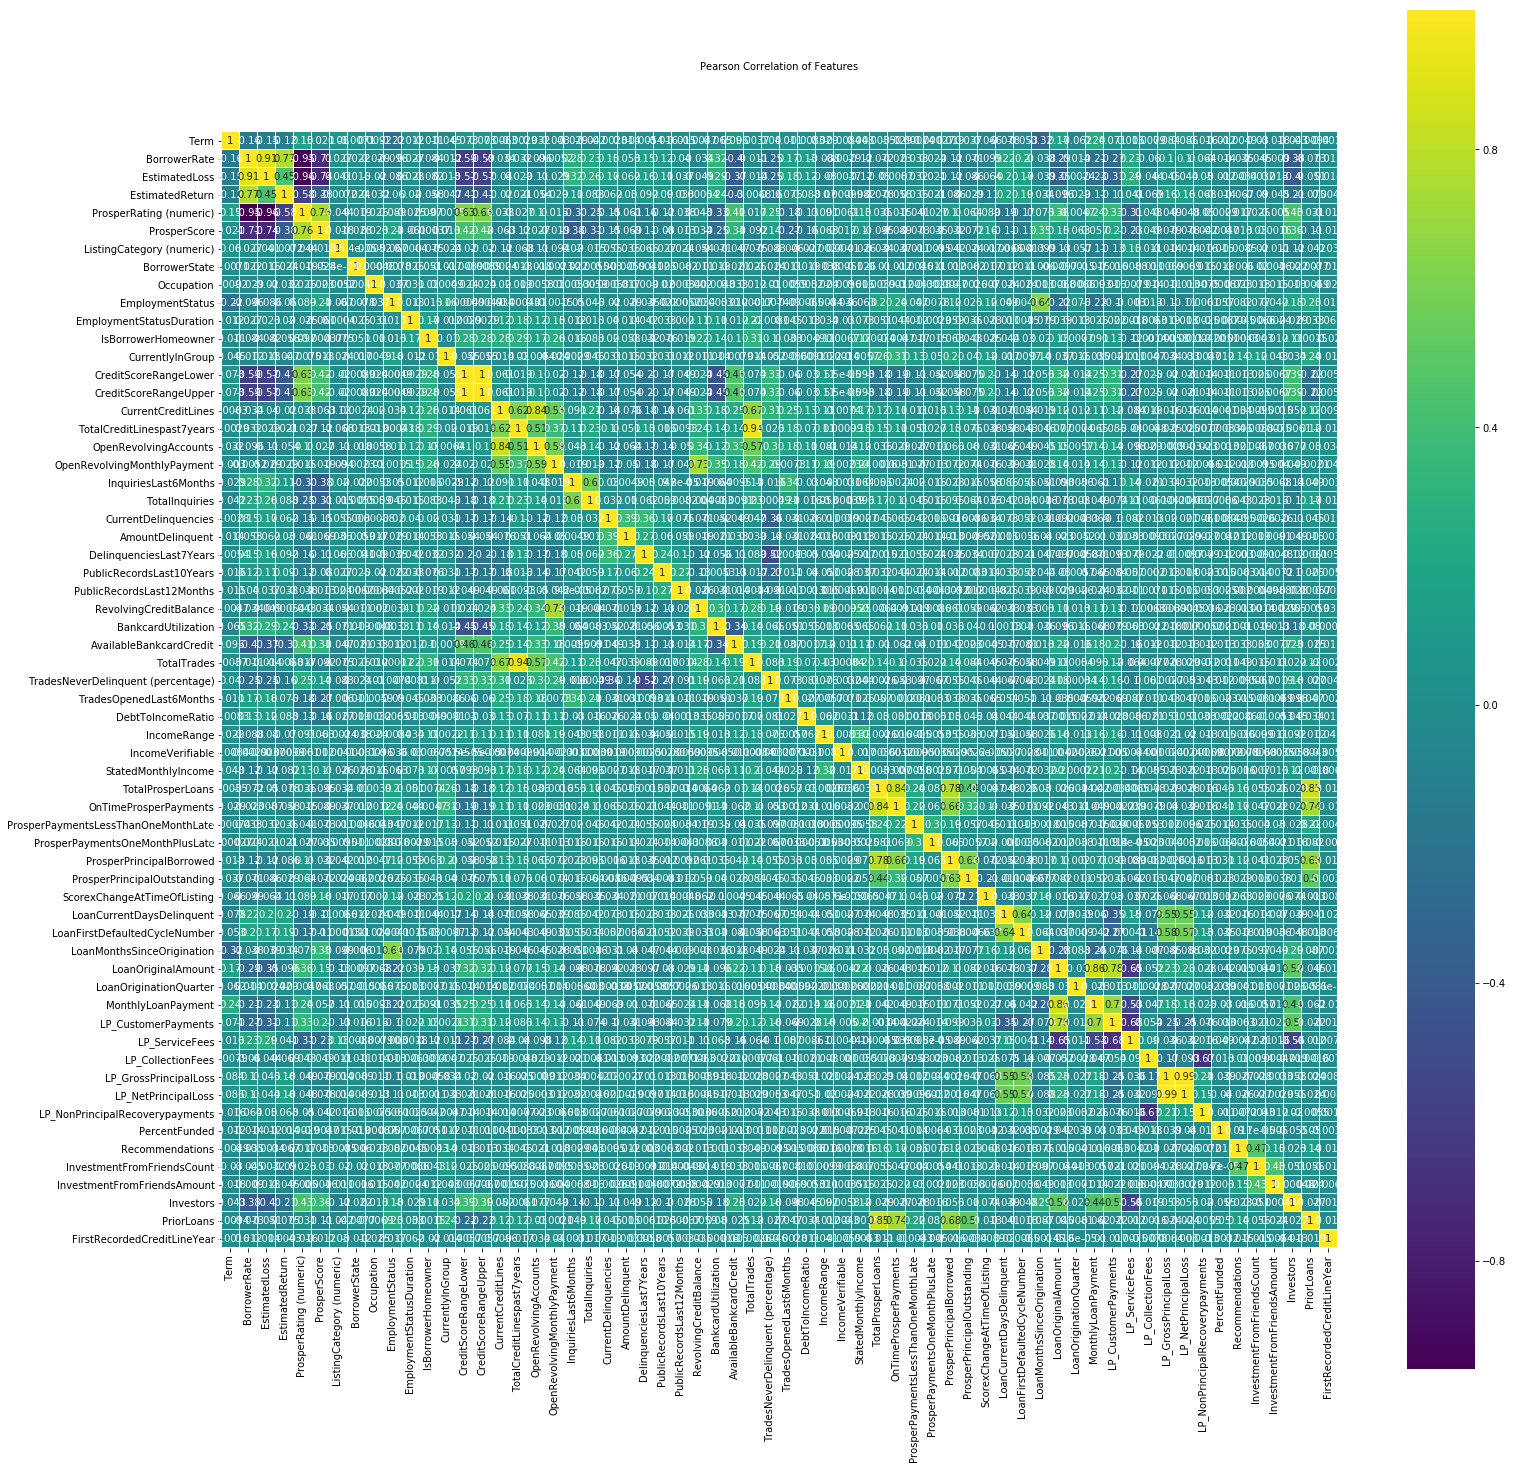

In [22]:
### 考察变量间相关性
colormap = plt.cm.viridis
plt.figure(figsize=(25,25))
plt.title('Pearson Correlation of Features', y=1.05, size=10)
sns.heatmap(corr.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [23]:
### 相关性结论：相关性>0.7的特征包括：
### 1.'BorrowerRate'/'EstimatedLoss'/'EstimatedReturn'/'ProsperRating (numeric)'/'ProsperScore'
### 2.‘CreditScoreRangeLower’/‘CreditScoreRangeUpper’
### 3.‘CurrentCreditLines’/‘OpenRevolvingAccounts’
### 4.‘OpenRevolvingMonthlyPayment’/‘RevolvingCreditBalance’
### 5.‘TotalTrades’/‘TotalCreditLinespast7years’
### 6.‘TotalProsperLoans’/'OnTimeProsperPayments'/'ProsperPrincipalBorrowed'/'PriorLoans'
### 7.'LoanOriginalAmount'/'MonthlyLoanPayment'/'LP_CustomerPayments'
### 8.'LP_GrossPrincipalLoss'/'LP_NetPrincipalLoss'

In [24]:
## 删除相关度大于0.7的特征
df_model = df_model.drop(['BorrowerAPR',
              'LenderYield',
              'EstimatedEffectiveYield',
              'OpenCreditLines',
              'TotalProsperPaymentsBilled',
              'LP_CustomerPrincipalPayments',
              'LP_InterestandFees',
              'EstimatedLoss',
              'EstimatedReturn',
              'ProsperRating (numeric)',
              'ProsperScore',
              'CreditScoreRangeLower',
              'OpenRevolvingAccounts',
              'RevolvingCreditBalance',
              'TotalCreditLinespast7years',
              'OnTimeProsperPayments',
              'ProsperPrincipalBorrowed',
              'PriorLoans',
              'MonthlyLoanPayment',
              'LP_CustomerPayments',
              'LP_NetPrincipalLoss'],
               axis=1)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25046 entries, 12 to 113935
Data columns (total 49 columns):
Term                                   25046 non-null uint8
LoanStatus                             25046 non-null bool
BorrowerRate                           25046 non-null float64
ListingCategory (numeric)              25046 non-null int64
BorrowerState                          25046 non-null int64
Occupation                             25046 non-null int64
EmploymentStatus                       25046 non-null uint8
EmploymentStatusDuration               25046 non-null float64
IsBorrowerHomeowner                    25046 non-null bool
CurrentlyInGroup                       25046 non-null bool
CreditScoreRangeUpper                  25046 non-null float64
CurrentCreditLines                     25046 non-null float64
OpenRevolvingMonthlyPayment            25046 non-null float64
InquiriesLast6Months                   25046 non-null float64
TotalInquiries                         2

In [25]:
## 将训练数据和测试数据分开

feature_cols = [i for i in df_model.columns if i != 'LoanStatus']
X_1 = df_model[feature_cols]
y_1 = df_model['LoanStatus']

X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(X_1,y_1,test_size=0.2)

In [26]:
## 特征选择——>单变量选择法

selectKBest = SelectKBest(k=15)
selectKBest.fit_transform(X_train_1,y_train_1)
### 提取到的特征
X_train_1.columns[selectKBest.get_support()]

Index(['Term', 'BorrowerRate', 'EmploymentStatus', 'CreditScoreRangeUpper',
       'AvailableBankcardCredit', 'TradesNeverDelinquent (percentage)',
       'TradesOpenedLast6Months', 'ScorexChangeAtTimeOfListing',
       'LoanCurrentDaysDelinquent', 'LoanFirstDefaultedCycleNumber',
       'LoanMonthsSinceOrigination', 'LP_CollectionFees',
       'LP_GrossPrincipalLoss', 'LP_NonPrincipalRecoverypayments',
       'Investors'],
      dtype='object')

In [27]:
## 根据选择出的特征重新划分训练集和测试集

X = df_model[['Term', 
              'BorrowerRate', 
              'EmploymentStatus', 
              'CreditScoreRangeUpper',
              'CurrentDelinquencies', 
              'AvailableBankcardCredit',
              'StatedMonthlyIncome',
              'ScorexChangeAtTimeOfListing',
              'LoanCurrentDaysDelinquent', 
              'LoanFirstDefaultedCycleNumber',
              'LoanMonthsSinceOrigination', 
              'LP_CollectionFees',
              'LP_GrossPrincipalLoss', 
              'LP_NonPrincipalRecoverypayments',
              'Investors']]

y = df_model['LoanStatus']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [28]:
# 建立逻辑回归模型

log_model = LogisticRegression()

In [29]:
## 用训练数据拟合模型
log_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
## 模型评分
log_model.score(X_test,y_test)

0.9726546906187625

In [31]:
## 模型预测
y_pred = log_model.predict(X_test)

In [32]:
## 十折交叉验证(测试集得分)
cross_val_score(log_model,X,y,cv=10).mean()

0.971891853422193

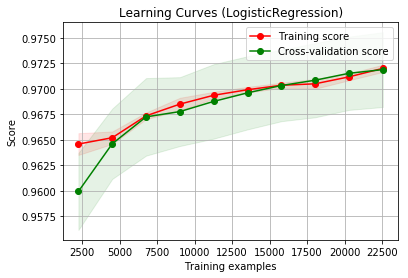

In [33]:
## 学习曲线

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (LogisticRegression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
cv=10
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

plt.show()